## Introduction

In this tutorial, you will learn how to:
1. Use the Fiedler vector to identify **bridge edges** (bottlenecks) in a network
2. Compute **edge energy** to quantify the tension across each edge
3. Implement an algorithm to find **communities** (groups of nodes tightly connected) by iteratively removing bridges.

**Key concept**: The Fiedler vector $\mathbf{w}_2$ minimizes edge energy $\sum_{(i,j)} A_{ij}(w_2(i) - w_2(j))^2$. Edges with large $(w_2(i) - w_2(j))^2$ are **bridges** that weakly connect otherwise dense regions.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

### Helper functions (PROVIDED)

In [2]:
def ring_of_cliques_adjacency(clique_size: int = 5, n_cliques: int = 4):
    """Return cliques connected in a ring by single bridging edges."""
    cliques = [nx.complete_graph(clique_size) for _ in range(n_cliques)]
    ring = nx.disjoint_union_all(cliques)
    offsets = [i * clique_size for i in range(n_cliques)]
    for i in range(n_cliques):
        ring.add_edge(offsets[i], offsets[(i + 1) % n_cliques])
    return nx.to_numpy_array(ring, dtype=float)


def plot_network_with_edge_colors(
    adj_matrix,
    node_colors = None,
    edge_energies = None,
    title: str = "",
) -> None:
    """Visualize network with nodes colored by Fiedler vector and edges by energy."""
    G = nx.from_numpy_array(adj_matrix)
    pos = nx.spring_layout(G, seed=42)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Draw edges
    if edge_energies is not None:
        edges = list(edge_energies.keys())
        weights = [edge_energies[e] for e in edges]
        # Normalize for visualization
        if len(weights) > 0:
            max_weight = max(weights)
            widths = [1 + 5 * (w / max_weight) for w in weights]
        else:
            widths = [1] * len(edges)
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=widths, 
                             edge_color=weights, edge_cmap=plt.cm.Reds,
                             edge_vmin=0, ax=ax)
    else:
        nx.draw_networkx_edges(G, pos, ax=ax)
    
    # Draw nodes
    if node_colors is not None:
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                              cmap=plt.cm.coolwarm, node_size=200, ax=ax)
    else:
        nx.draw_networkx_nodes(G, pos, node_size=200, ax=ax)
    
    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

## Section 1: Computing Edge Energy

### Task 1: Implement edge energy computation

The **edge energy** for edge $(i,j)$ with respect to a vector $\mathbf{v}$ is:
$$
E_{ij}[\mathbf{v}] = A_{ij} \cdot (v_i - v_j)^2
$$

For the Fiedler vector $\mathbf{w}_2$, edges with high energy are bottlenecks.

**Your task**:
1. Implement `fiedler_vector(adj_matrix)` that computes and returns the Fiedler vector of the graph represented by `adj_matrix`.
2. Implement `compute_edge_energy(adj_matrix, vector)` that returns a dictionary mapping each edge `(i, j)` to its energy.

In [ ]:
def fiedler_vector(adj_matrix: np.ndarray):
    """Return the algebraic connectivity and its corresponding eigenvector."""
    A = nx.from_numpy_array(adj_matrix)
    L = nx.laplacian_matrix(A).toarray()
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    
    # lambda_2 is the second smallest eigenvalue
    #lambda_2 : algebraic connectivity
    lambda_two = eigenvalues[1]
    
    #fielder vector is the vector associated to the min value lambda_2
    fiedler_vec = eigenvectors[:, 1]
    
   
    return lambda_two, fiedler_vec

In [6]:
def compute_edge_energy(adj_matrix: np.ndarray, vector: np.ndarray):
    """
    Returns:
        Dict: Mapping from edge (i, j) to its energy.
    """
    
    #dictionary to store edge energies
    edge_energy = {}
    
    #edge energy formula: Aij * (v_i - v_j)^2
    
    v = vector
    A = adj_matrix
    
    for i, j in zip(*np.where(A > 0)):
        energy = A[i, j] * (v[i] - v[j])**2
        edge_energy[(i, j)] = energy
        
        
    
    return edge_energy

### Test your implementation running the following cells:

In [56]:
# Create a simple ring of 6 cliques of 5 nodes each
adj = ring_of_cliques_adjacency(clique_size=5, n_cliques=6)

# Compute Fiedler vector
omega2, w2 = fiedler_vector(adj)
print(f"Algebraic connectivity: {omega2:.4f}")

# Compute edge energies
edge_energy = compute_edge_energy(adj, w2)
print("\nEdge energies:", edge_energy)

# Display top 5 edges with highest energy (these should be bridges)
sorted_edges = sorted(edge_energy.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 edges with highest energy:")
for edge, energy in sorted_edges[:5]:
    print(f"  Edge {edge}: energy = {energy:.4f}")

Algebraic connectivity: 0.1716

Edge energies: {(0, 1): 0.0012923064793524963, (0, 2): 0.0012923064793525063, (0, 3): 0.0012923064793525084, (0, 4): 0.0012923064793525084, (0, 5): 0.0009984665228526394, (0, 25): 0.04209638162953735, (1, 0): 0.0012923064793524963, (1, 2): 1.9259299443872359e-32, (1, 3): 2.7733391199176196e-32, (1, 4): 2.7733391199176196e-32, (2, 0): 0.0012923064793525063, (2, 1): 1.9259299443872359e-32, (2, 3): 7.703719777548943e-34, (2, 4): 7.703719777548943e-34, (3, 0): 0.0012923064793525084, (3, 1): 2.7733391199176196e-32, (3, 2): 7.703719777548943e-34, (3, 4): 0.0, (4, 0): 0.0012923064793525084, (4, 1): 2.7733391199176196e-32, (4, 2): 7.703719777548943e-34, (4, 3): 0.0, (5, 0): 0.0009984665228526394, (5, 6): 0.0018056493084903586, (5, 7): 0.001805649308490328, (5, 8): 0.0018056493084903397, (5, 9): 0.001805649308490335, (5, 10): 0.03012845655097329, (6, 5): 0.0018056493084903586, (6, 7): 1.3019286424057714e-31, (6, 8): 4.930380657631324e-32, (6, 9): 7.70371977754894

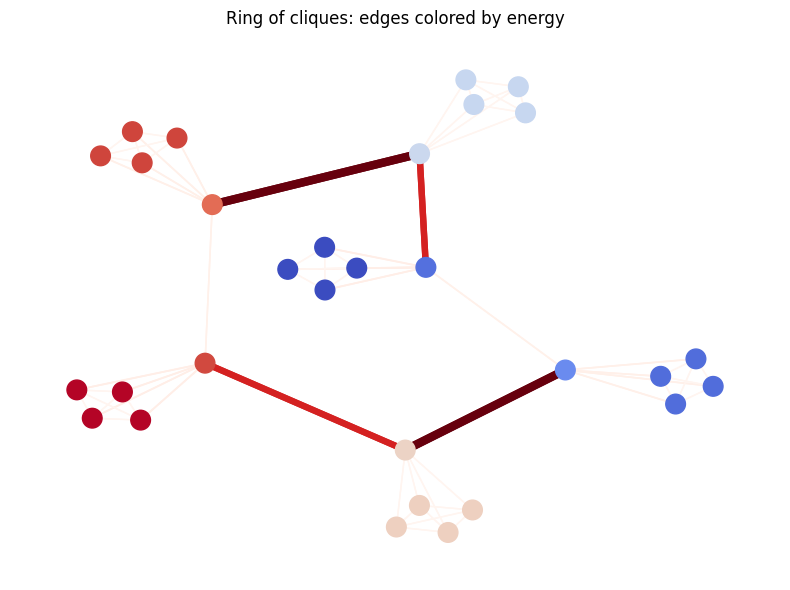

In [8]:
# Visualize the network
plot_network_with_edge_colors(adj, node_colors=w2, edge_energies=edge_energy, title="Ring of cliques: edges colored by energy")

## Section 2: Identifying Bridge Edges

### Task 2.1: Implement bridge detection

**Your task**:
1. Implement `find_bridge_edges(adj_matrix, n_bridges)` that:
   - Computes the Fiedler vector
   - Computes edge energies
   - Returns the `n_bridges` edges with highest energy as a list of tuples.
2. Test on the ring-of-cliques graph

In [39]:
def find_bridge_edges(adj_matrix, n_bridges = 1):
    
    #check!
    total_nodes = adj_matrix.shape[0]
    print(f"Total number of nodes in the network: {total_nodes}")
    
    total_bridges = 0
    for i, j in zip(*np.where(adj_matrix > 0)):
        total_bridges += 1

    print(f"Total number of edges in the network: {total_bridges}")
    if n_bridges >= total_bridges:
        print(f"n_bridges must be less than the total number of edges {total_bridges}")
        return 0
    
    A = adj_matrix
    L = nx.laplacian_matrix(nx.from_numpy_array(A)).toarray()
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    fiedler_vec = eigenvectors[:, 1]
    algebraic_connectivity = eigenvalues[1]
    
    # use the previous function to compute edge energies
    edge_energy = compute_edge_energy(adj_matrix, fiedler_vec)
    
    #sort edges 
    sorted_edges = sorted(edge_energy.items(), key=lambda x: x[1], reverse=True)
    
    #get to n edges
    top_n_edges = sorted_edges[:n_bridges]
    
    #from the top n edges get the briges (i, j)
    bridges = [edge for edge, energy in top_n_edges]

    
    
    return bridges

In [57]:
# Test on the adjacency of the graph created above
bridges = find_bridge_edges(adj, n_bridges=4)

print("Identified bridge edges:")
for edge in bridges:
    print(f"  {edge}")

Total number of nodes in the network: 30
Total number of edges in the network: 132
Identified bridge edges:
  (0, 25)
  (25, 0)
  (10, 15)
  (15, 10)


## Section 3: Block Decomposition by Edge Removal (Challenging task)

### Task 3: Implement iterative block decomposition

**The Challenge**: We want to identify natural communities (blocks) by removing bridge edges. But how do we decide which edges to remove?

**Naive approach (doesn't work)**: Simply set an energy threshold and remove all edges above it. Problem: as we remove edges, the network gets smaller, and energy scales change dramatically. A "low" energy in a large component becomes "high" in a small one.

**Solution: Z-score normalization**

The **z-score** (or standard score) measures how many standard deviations a value is from the mean:

$$
z = \frac{x - \mu}{\sigma}
$$
where $\mu$ is the mean and $\sigma$ is the standard deviation.

**The Algorithm**:

**Input**: Adjacency matrix, z-score threshold $\theta$, minimum component size
å
**Repeat until all components are "blocked"**:
1. Find all connected components in current graph
2. For each component:
   - Compute Fiedler vector $\mathbf{w}_2$ and edge energies $E_{ij} = (w_2(i) - w_2(j))^2$
   - Compute mean energy: $\mu = \frac{1}{m}\sum_{(i,j)} E_{ij}$
   - Compute standard deviation: $\sigma = \sqrt{\frac{1}{m}\sum_{(i,j)} (E_{ij} - \mu)^2}$
   - Compute z-score for each edge: $z_{ij} = \frac{E_{ij} - \mu}{\sigma}$
3. Select the component with **lowest algebraic connectivity** $\omega_2$ (the one where diffusion is slowest)
4. In that component, find edge with **highest z-score** (the outlier)
5. **If** z-score $> \theta$: 
   - Remove the edge
   - Continue to next iteration
6. **Else**: 
   - Mark component as "blocked" (no more bridges are present)
   - Continue with other components

**Output**: List of blocks
Example of output:
list of blocks: `[[0,1,2],[3,4,5],[6,7]]` --> three communities in three lists. Each list contains node indices belonging to that community.

#### SUGGESTIONS:
To find connected components, you can use NetworkX:
```python
G = nx.from_numpy_array(adj) # create graph from adjacency matrix
components = list(nx.connected_components(G)) # get connected components
```

In [97]:
# ...existing code...
def decompose_into_blocks(adj_matrix, energy_threshold = 2.0):
    """
    Iteratively remove bridge edges using per-component z-score normalization of edge energies.
    energy_threshold is interpreted as the z-score threshold (theta).
    Returns: list of connected components (as sets) after decomposition.
    """
    A = adj_matrix.copy()
    z_thresh = energy_threshold

    # Keep track of components we marked as blocked (store as frozenset of nodes)
    blocked = set()

    while True:
        G = nx.from_numpy_array(A)
        components = list(nx.connected_components(G))

        # build list of candidate info for each non-blocked component
        candidates = []  # tuples: (lambda2, component_nodes_set, max_z, best_edge)
        for comp in components:
            
            #frozenset is the immutable version of set
            comp_frozen = frozenset(comp)
            if comp_frozen in blocked:
                continue
            if len(comp) < 2:
                # no edges to remove
                blocked.add(comp_frozen)
                continue
            
            #work on the cirrent component
            # build subgraph adjacency and mapping to local indices
            sub_nodes = list(comp)
            subgraph = G.subgraph(sub_nodes)
            sub_A = nx.to_numpy_array(subgraph)  
            
            # compute fiedler vector for this component
            lambda2, v_sub = fiedler_vector(sub_A)

            # compute edge energies for unique undirected edges (use subgraph.edges())
            energies = {}
            node_to_pos = {node: pos for pos, node in enumerate(sub_nodes)}
            for i, j in subgraph.edges():
                pi = node_to_pos[i]
                pj = node_to_pos[j]
                energy = sub_A[pi, pj] * (v_sub[pi] - v_sub[pj])**2
                key = tuple(sorted((i, j)))
                energies[key] = energy


            if len(energies) == 0:
                blocked.add(comp_frozen)
                continue

            #vals contains all the energy values
            vals = np.fromiter(energies.values(), dtype=float)
            mu = vals.mean()
            sigma = vals.std(ddof=0)

            # compute z-scores and find max
            best_edge = None
            max_z = -np.inf
            for edge, e in energies.items():
                z = (e - mu) / sigma
                if z > max_z:
                    max_z = z
                    best_edge = edge

            candidates.append((lambda2, comp_frozen, max_z, best_edge))

        if len(candidates) == 0:
            # nothing left to do
            break

        # select component with lowest algebraic connectivity
        candidates.sort(key=lambda x: x[0])
        lambda2_sel, comp_sel, max_z_sel, edge_sel = candidates[0]

        if edge_sel is None:
            blocked.add(comp_sel)
            continue

        if max_z_sel > z_thresh:
            i, j = edge_sel
            # remove edge from adjacency (original indices)
            A[i, j] = 0
            A[j, i] = 0
            # when topology changed, reset blocked set because components changed
            blocked = set()
            # continue loop to recompute components
            continue
        else:
            # mark selected component blocked and continue
            blocked.add(comp_sel)
            # check if all current components are blocked
            all_blocked = True
            for comp in nx.connected_components(nx.from_numpy_array(A)):
                if frozenset(comp) not in blocked and len(comp) >= 2:
                    all_blocked = False
                    break
            if all_blocked:
                break
            else:
                continue

    
    final_blocks = list(nx.connected_components(nx.from_numpy_array(A)))
    return final_blocks


### Test on ring of cliques by running this code

In [95]:
# Decompose into blocks (z-score threshold of 2.0 means edge must be 2 std above mean)
blocks = decompose_into_blocks(adj, energy_threshold=3.5)

print(f"Found {len(blocks)} blocks:")
for i, block in enumerate(blocks):
    print(f"  Block {i+1}: {len(block)} nodes")

Found 6 blocks:
  Block 1: 5 nodes
  Block 2: 5 nodes
  Block 3: 5 nodes
  Block 4: 5 nodes
  Block 5: 5 nodes
  Block 6: 5 nodes


# Visualize the decomposition with the code provided below

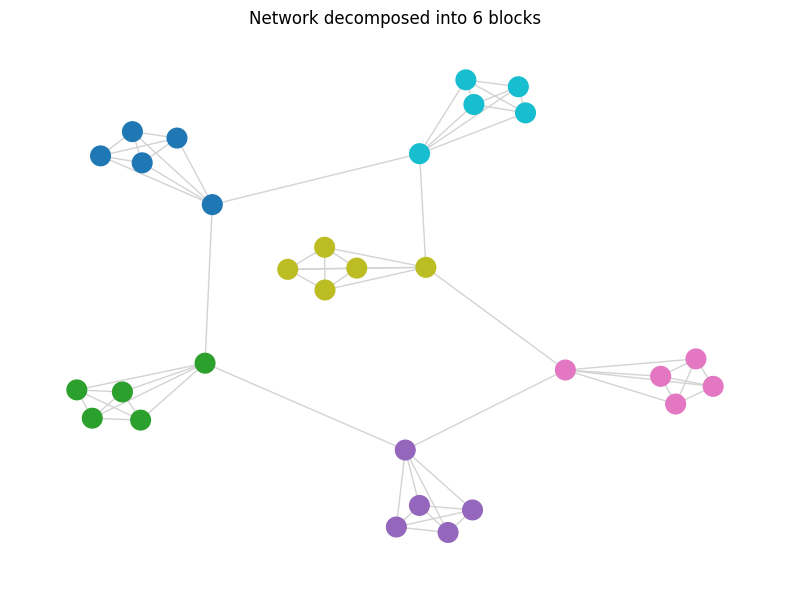

In [96]:
def plot_blocks(adj_matrix, blocks):
    """Visualize network with nodes colored by block membership."""
    G = nx.from_numpy_array(adj_matrix)
    pos = nx.spring_layout(G, seed=42)
    
    # Assign color to each node based on block
    n = adj_matrix.shape[0]
    node_colors = np.zeros(n)
    for block_id, block in enumerate(blocks):
        for node in block:
            node_colors[node] = block_id
    
    fig, ax = plt.subplots(figsize=(8, 6))
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          cmap=plt.cm.tab10, node_size=200, ax=ax)
    ax.set_title(f"Network decomposed into {len(blocks)} blocks")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_blocks(adj, blocks)